# The Battle of Neighborhoods

In [1]:
#Import libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


# Extract and transform the data

Extact localities information from Wikipedia

In [2]:
import lxml.html as lh
url='https://es.wikipedia.org/wiki/Anexo:Localidades_de_Bogot%C3%A1'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

Transform the extracted data

In [3]:
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))

In [4]:
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    #i is the index of our column
    i=0
    #Iterate through each element of the row
    for t in T.iterchildren():
        if i<6:
            data=t.text_content()
            data=data[:-1]
            if i==4 or i==5:
                data=data.replace(u'\xa0',u'')
                data=data.replace(' ','')
            #Append the data to the empty list of the i'th column
            col[i][1].append(data)
            #Increment i for the next column
            i+=1

Convert into DataFrame

In [5]:
Dict={title:column for (title,column) in col}
df_localities=pd.DataFrame(Dict)
df_localities.columns=['Number','Locality','Postcode','Surface','Population','Density']
df_localities['Surface']=df_localities['Surface'].astype('float')
df_localities['Density']=df_localities['Density'].astype('float')
df_localities['Number']=df_localities['Number'].astype('int32')
df_localities['Population']=df_localities['Population'].astype('int32')
df_localities

,Number,Locality,Postcode,Surface,Population,Density
0,1,Usaquén,110111-110151,65.31,501999,7686.40
1,2,Chapinero,110211-110231,38.15,139701,3661.88
2,3,Santa Fe,110311-110321,45.17,110048,2436.30
3,4,San Cristóbal,110411-110441,49.09,404697,8243.98
4,5,Usme,110511-110571,215.06,457302,2126.39
5,6,Tunjuelito,110611-110621,9.91,199430,20124.11
6,7,Bosa,110711-110741,23.93,673077,28126.91
7,8,Kennedy,110811-110881,38.59,1088443,28205.31
8,9,Fontibón,110911-110931,33.28,394648,11858.41
9,10,Engativá,111011-111071,35.88,887080,24723.52


Search geographical coordinate of Bogotá, Colombia

In [6]:
address = 'Bogotá, Colombia'

geolocator = Nominatim(user_agent="bo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bogotá are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bogotá are 4.59808, -74.0760439.


Create DataFrame for localities geographical cordinate

In [7]:
col_names=['Locality','Latitude','Longitude']
df_coord=pd.DataFrame(columns=col_names)

In [8]:
for i in range(0,len(df_localities)):
    locality = df_localities.iloc[i,1]+', Bogotá'
    geolocator = Nominatim(user_agent="bo_explorer")
    location = geolocator.geocode(locality)
    lat = location.latitude
    lng = location.longitude
    df_coord=df_coord.append({'Locality':df_localities.iloc[i,1],
                              'Latitude':lat,
                              'Longitude':lng}, ignore_index=True)
df_coord

,Locality,Latitude,Longitude
0,Usaquén,4.694969,-74.031093
1,Chapinero,4.645377,-74.061943
2,Santa Fe,4.602204,-74.078837
3,San Cristóbal,4.548658,-74.047473
4,Usme,4.508155,-74.114328
5,Tunjuelito,4.561049,-74.127523
6,Bosa,4.625492,-74.200280
7,Kennedy,4.629682,-74.149935
8,Fontibón,4.673327,-74.144732
9,Engativá,4.708695,-74.109643


Create map with localities data

In [9]:
# create map of Bogotá using latitude and longitude values
map_bogota = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for  locality,lat, lng in zip( df_coord['Locality'],df_coord['Latitude'], df_coord['Longitude'],):
    label = locality
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota)  
    
map_bogota

Api Foursquare information

In [10]:
CLIENT_ID = 'TM2K1HBQXOSQXGYJGEBLJE015NBIQWL4BI45VH2KW1KBZQBX' # my Foursquare ID
CLIENT_SECRET = 'TDHZMKLFZJ2DCL21WMOW4PVMHT2Z1UODUCVVVNKOP5P0QW5B' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: TM2K1HBQXOSQXGYJGEBLJE015NBIQWL4BI45VH2KW1KBZQBX
CLIENT_SECRET:TDHZMKLFZJ2DCL21WMOW4PVMHT2Z1UODUCVVVNKOP5P0QW5B


Search all the supermarkets present in each locality for each of the networks

In [11]:
import math
col_names=['Locality','D1','Ara','Oxxo','Exito']
df_counts=pd.DataFrame(columns=col_names)
s_networks=['D1','Ara','Oxxo','Exito']
categories='Market,Supermarket,Grocery Store,Departament Store,Flea Market,Big Box Store,Shop & Service,Gourmet Shop,Miscellaneous Shop,Convenience Store'

for j in range(0,len(s_networks)):
    network=s_networks[j]
    for i in range(0,len(df_localities)):
        lat=df_coord.iloc[i,1]
        lng=df_coord.iloc[i,2]
        area=df_localities.iloc[i,3]
        radius = math.sqrt(area/math.pi)*1000
        
        # create URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius,
        network)

        results = requests.get(url).json()
        no_results=len(results['response']['venues'])
        if no_results>0:
            no_supermarkets=0
            for k in range(0,no_results):
                reg=len(results['response']['venues'][k]['categories'])
                if reg>0:
                    category=results['response']['venues'][k]['categories'][0]['name']
                    if categories.find(category)>-1:
                        no_supermarkets=no_supermarkets+1
                        
        if j==0:
            df_counts=df_counts.append({s_networks[j]:no_supermarkets,'Locality':df_localities.iloc[i,1]},ignore_index=True)
        else:
            df_counts.iloc[i,j+1]=no_supermarkets
            

In [12]:
df_counts

,Locality,D1,Ara,Oxxo,Exito
0,Usaquén,29,12,16,22
1,Chapinero,20,10,20,15
2,Santa Fe,2,7,11,23
3,San Cristóbal,0,7,11,23
4,Usme,5,4,1,7
5,Tunjuelito,3,2,1,1
6,Bosa,1,0,1,1
7,Kennedy,3,0,2,8
8,Fontibón,3,4,1,6
9,Engativá,7,4,2,7


Example: 
In the locality of "Puente Aranda" there are "6" supermarkets of the "Exito" network

# Clustering Model

Run k-means to cluster the Localities into 7 clusters acording to supermarkets number present in each locality

In [13]:
# set number of clusters
kclusters = 7

df_data = df_counts.drop('Locality', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 2, 3, 3, 5, 1, 1, 5, 5, 5], dtype=int32)

In [14]:
df_counts.insert(5, 'Cluster Labels', kmeans.labels_)

Create the map with clusters obtained

In [15]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_coord['Latitude'],df_coord['Longitude'], df_counts['Locality'], df_counts['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


# Cluster Analysis

Create a DataFrame with the supermarkets sum by each cluster

In [16]:
col_names=['Cluster Labels','D1','Ara','Oxxo','Exito']
df_sum=pd.DataFrame(columns=col_names)

In [17]:
for i in range(0,kclusters):
    df_filter=df_counts[df_counts['Cluster Labels']==i]
    for j in range(0,5):
        if j==0:
            df_sum=df_sum.append({'Cluster Labels':i},ignore_index=True)
        if j>0:
            df_sum.iloc[i,j]=df_filter[col_names[j]].sum()
df_sum

,Cluster Labels,D1,Ara,Oxxo,Exito
0,0.0,25.0,8.0,12.0,37.0
1,1.0,11.0,3.0,12.0,11.0
2,2.0,20.0,10.0,20.0,15.0
3,3.0,2.0,14.0,22.0,46.0
4,4.0,24.0,5.0,6.0,9.0
5,5.0,24.0,16.0,8.0,38.0
6,6.0,29.0,12.0,16.0,22.0


Create a DataFrame with market share percentage by each network and each cluster

In [18]:
df_market=pd.DataFrame(columns=col_names)
for i in range(0,kclusters):
    summ=df_sum['D1'][i]+df_sum['Ara'][i]+df_sum['Oxxo'][i]+df_sum['Exito'][i]
    for j in range(0,5):
        if j==0:
            df_market=df_market.append({'Cluster Labels':i},ignore_index=True)
        if j>0:
            df_market.iloc[i,j]=round((df_sum[col_names[j]][i]/summ)*100,1)

Compute the total market share percentage by each network

In [19]:
t_sum=df_sum.sum()[1:5].sum()
ms_d1=round(df_sum['D1'].sum()/t_sum*100,1)
ms_ara=round(df_sum['Ara'].sum()/t_sum*100,1)
ms_oxxo=round(df_sum['Oxxo'].sum()/t_sum*100,1)
ms_exito=round(df_sum['Exito'].sum()/t_sum*100,1)
print('Total market share by D1: '+str(ms_d1)+'%')
print('Total market share by Ara: '+str(ms_ara)+'%')
print('Total market share by Oxxo: '+str(ms_oxxo)+'%')
print('Total market share by Exito: '+str(ms_exito)+'%')

Total market share by D1: 28.3%
Total market share by Ara: 14.3%
Total market share by Oxxo: 20.1%
Total market share by Exito: 37.3%


Visualice the market share perchentage by each network in each cluster

### Cluster 0

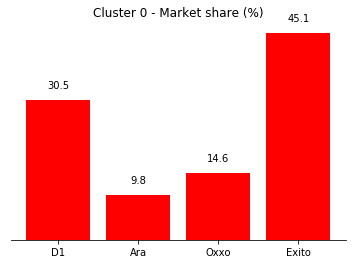

In [27]:
#-*- coding: utf-8 -*-
import matplotlib.pyplot as plt

fig = plt.figure('Market share') # Figure
ax = fig.add_subplot(111) # Axes

cluster=0
data=[df_market['D1'][cluster],df_market['Ara'][cluster],df_market['Oxxo'][cluster],df_market['Exito'][cluster]]
xx=range(len(data))

index=np.arange(4)
labels=data
for label, x, y in zip(labels,index,labels):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0,10),
        textcoords='offset points', ha='center', va='bottom',fontsize=10)
      
ax.bar(xx, data, width=0.8, align='center',color=rainbow[cluster-1],label=df_market)
ax.set_xticks(xx)
ax.set_xticklabels(['D1','Ara','Oxxo','Exito'])
plt.title('Cluster ' + str(cluster) +' - Market share (%)')
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

### Cluster 1

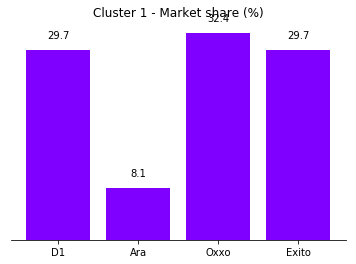

In [21]:
#-*- coding: utf-8 -*-
import matplotlib.pyplot as plt

fig = plt.figure('Market share') # Figure
ax = fig.add_subplot(111) # Axes

cluster=1
data=[df_market['D1'][cluster],df_market['Ara'][cluster],df_market['Oxxo'][cluster],df_market['Exito'][cluster]]
xx=range(len(data))

index=np.arange(4)
labels=data
for label, x, y in zip(labels,index,labels):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0,10),
        textcoords='offset points', ha='center', va='bottom',fontsize=10)
      
ax.bar(xx, data, width=0.8, align='center',color=rainbow[cluster-1],label=df_market)
ax.set_xticks(xx)
ax.set_xticklabels(['D1','Ara','Oxxo','Exito'])
plt.title('Cluster ' + str(cluster) +' - Market share (%)')
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

### Cluster 2

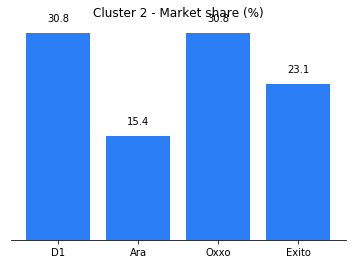

In [22]:
#-*- coding: utf-8 -*-
import matplotlib.pyplot as plt

fig = plt.figure('Market share') # Figure
ax = fig.add_subplot(111) # Axes

cluster=2
data=[df_market['D1'][cluster],df_market['Ara'][cluster],df_market['Oxxo'][cluster],df_market['Exito'][cluster]]
xx=range(len(data))

index=np.arange(4)
labels=data
for label, x, y in zip(labels,index,labels):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0,10),
        textcoords='offset points', ha='center', va='bottom',fontsize=10)
      
ax.bar(xx, data, width=0.8, align='center',color=rainbow[cluster-1],label=df_market)
ax.set_xticks(xx)
ax.set_xticklabels(['D1','Ara','Oxxo','Exito'])
plt.title('Cluster ' + str(cluster) +' - Market share (%)')
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

### Cluster 3

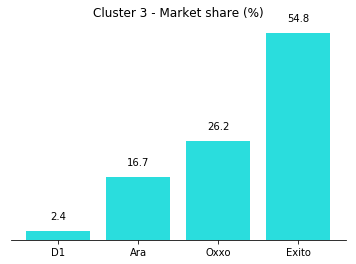

In [23]:
#-*- coding: utf-8 -*-
import matplotlib.pyplot as plt

fig = plt.figure('Market share') # Figure
ax = fig.add_subplot(111) # Axes

cluster=3
data=[df_market['D1'][cluster],df_market['Ara'][cluster],df_market['Oxxo'][cluster],df_market['Exito'][cluster]]
xx=range(len(data))

index=np.arange(4)
labels=data
for label, x, y in zip(labels,index,labels):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0,10),
        textcoords='offset points', ha='center', va='bottom',fontsize=10)
      
ax.bar(xx, data, width=0.8, align='center',color=rainbow[cluster-1],label=df_market)
ax.set_xticks(xx)
ax.set_xticklabels(['D1','Ara','Oxxo','Exito'])
plt.title('Cluster ' + str(cluster) +' - Market share (%)')
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

### Cluster 4

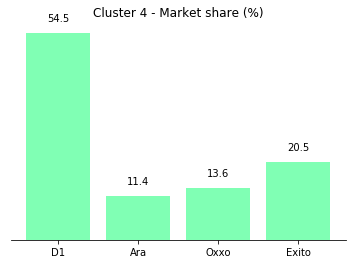

In [24]:
#-*- coding: utf-8 -*-
import matplotlib.pyplot as plt

fig = plt.figure('Market share') # Figure
ax = fig.add_subplot(111) # Axes

cluster=4
data=[df_market['D1'][cluster],df_market['Ara'][cluster],df_market['Oxxo'][cluster],df_market['Exito'][cluster]]
xx=range(len(data))

index=np.arange(4)
labels=data
for label, x, y in zip(labels,index,labels):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0,10),
        textcoords='offset points', ha='center', va='bottom',fontsize=10)
      
ax.bar(xx, data, width=0.8, align='center',color=rainbow[cluster-1],label=df_market)
ax.set_xticks(xx)
ax.set_xticklabels(['D1','Ara','Oxxo','Exito'])
plt.title('Cluster ' + str(cluster) +' - Market share (%)')
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

### Cluster 5

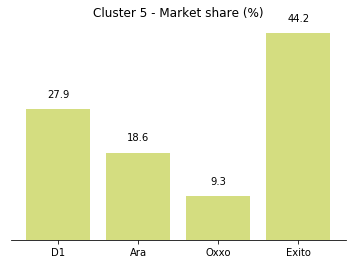

In [25]:
#-*- coding: utf-8 -*-
import matplotlib.pyplot as plt

fig = plt.figure('Market share') # Figure
ax = fig.add_subplot(111) # Axes

cluster=5
data=[df_market['D1'][cluster],df_market['Ara'][cluster],df_market['Oxxo'][cluster],df_market['Exito'][cluster]]
xx=range(len(data))

index=np.arange(4)
labels=data
for label, x, y in zip(labels,index,labels):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0,10),
        textcoords='offset points', ha='center', va='bottom',fontsize=10)
      
ax.bar(xx, data, width=0.8, align='center',color=rainbow[cluster-1],label=df_market)
ax.set_xticks(xx)
ax.set_xticklabels(['D1','Ara','Oxxo','Exito'])
plt.title('Cluster ' + str(cluster) +' - Market share (%)')
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

### Cluster 6

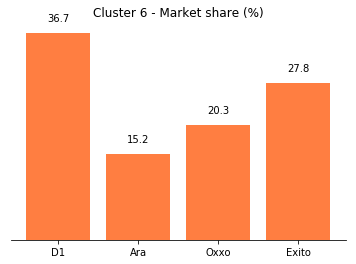

In [26]:
#-*- coding: utf-8 -*-
import matplotlib.pyplot as plt

fig = plt.figure('Market share') # Figure
ax = fig.add_subplot(111) # Axes

cluster=6
data=[df_market['D1'][cluster],df_market['Ara'][cluster],df_market['Oxxo'][cluster],df_market['Exito'][cluster]]
xx=range(len(data))

index=np.arange(4)
labels=data
for label, x, y in zip(labels,index,labels):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0,10),
        textcoords='offset points', ha='center', va='bottom',fontsize=10)
      
ax.bar(xx, data, width=0.8, align='center',color=rainbow[cluster-1],label=df_market)
ax.set_xticks(xx)
ax.set_xticklabels(['D1','Ara','Oxxo','Exito'])
plt.title('Cluster ' + str(cluster) +' - Market share (%)')
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

# Thanks for watching!!

If the maps are not displayed correctly, you can go to the following link:
https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/a229c018-4788-4e31-9663-fbb8b2f327e1/view?access_token=9dadd9ca8d084859da4b41e79ba2fdb1784aa668e09fe07b26528e5c130882ed